<a href="https://colab.research.google.com/github/h-neal/Matt-Macarty-Algorithmic-Trading-Youtube-Series/blob/main/5_Create_a_Mean_Reverting_Trading_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mean Reversion Trading Algorithm**

- Trading strategy that focuses on when a security moves "too" far away from some kind of average
- General idea is that it will move back toward the mean - at some point
- Many ways to look at this strategy, i.e. linear regression, moving average
- How far is too far?

In [4]:
!pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.59
    Uninstalling yfinance-0.2.59:
      Successfully uninstalled yfinance-0.2.59


In [47]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
import seaborn as sb
sb.set()

import yfinance as yf

In [83]:
gld = yf.download('GLD')
gld.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GLD,GLD,GLD,GLD,GLD
Date,,,,,
2004-11-18,44.380001,44.490002,44.070000,44.430000,5992000
2004-11-19,44.779999,44.919998,44.470001,44.490002,11655300
2004-11-22,44.950001,44.970001,44.740002,44.750000,11996000
2004-11-23,44.750000,44.919998,44.720001,44.880001,3169200
2004-11-24,45.049999,45.049999,44.790001,44.930000,6105100


In [87]:
if isinstance(gld.columns, pd.MultiIndex):
    gld.columns = gld.columns.get_level_values(0)

In [88]:
gld_close = gld[['Close']].copy().reset_index()

In [89]:
gld_close['Close'] = gld_close['Close'].astype(float)

In [101]:
ma = 21
gld_close['returns'] = np.log(gld_close['Close']).diff()
gld_close['ma'] = gld_close['Close'].rolling(ma).mean()
gld_close['ratio'] = gld_close['Close'] / gld_close['ma']

In [102]:
gld_close['ratio'].describe()

,ratio
count,5132.000000
mean,1.003932
std,0.027277
min,0.855820
25%,0.987714
50%,1.002868
75%,1.020727
max,1.114803


In [103]:
percentiles = [5, 10 , 50, 90 ,95]
p = np.percentile(gld_close['ratio'].dropna(), percentiles)

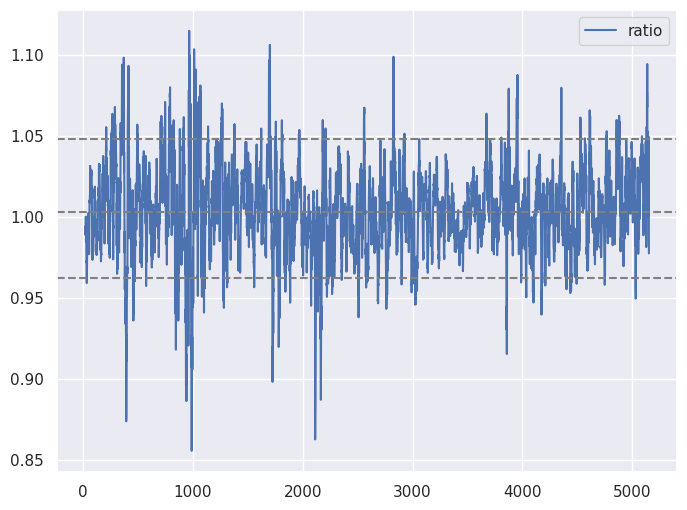

In [104]:
gld_close['ratio'].dropna().plot(legend=True)
plt.axhline(p[0], c= (.5, .5, .5), ls='--')
plt.axhline(p[2], c= (.5, .5, .5), ls='--')
plt.axhline(p[-1], c= (.5, .5, .5), ls='--');

In [105]:
short = p[-1]
long = p[0]
gld_close['position'] = np.where(gld_close['ratio'] > short, -1, np.nan)
gld_close['position'] = np.where(gld_close['ratio'] < long, 1, gld_close['position'])
gld_close['position'] = gld_close['position'].ffill().fillna(0)

<Axes: >

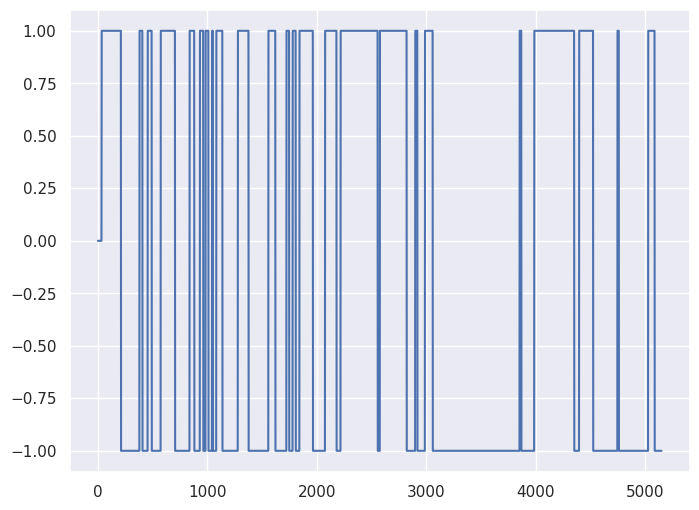

In [106]:
gld_close.position.dropna().plot()

In [107]:
gld_close['strat_return'] = gld_close['returns'] * gld_close['position'].shift()

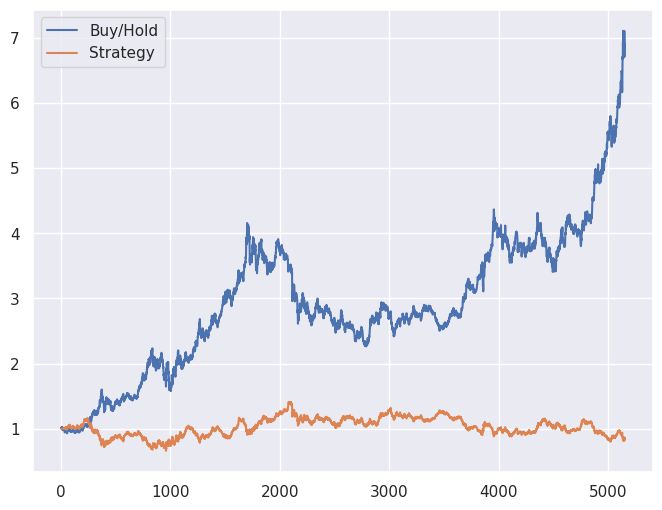

In [110]:
plt.plot(np.exp(gld_close['returns'].dropna()).cumprod(), label = 'Buy/Hold')
plt.plot(np.exp(gld_close['strat_return'].dropna()).cumprod(), label='Strategy')
plt.legend();